# 09 Dielectrics - PyTorch

* 기존 예제에서 for loop을 제거하고 PyTorch로 가속한 예제입니다.

In [1]:
from __future__ import annotations

import sys
from typing import List
from tqdm import tqdm

import torch
import torch.nn.functional as f
import numpy as np

import matplotlib.pyplot as plt

infinity = sys.float_info.max

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")   

print(device)

cuda


In [3]:
def blend(color1: torch.Tensor, color2: torch.Tensor, t_map: torch.Tensor) -> torch.Tensor:
    return (1.0 - t_map) * color1 + t_map * color2


def dot(v1: torch.Tensor, v2: torch.Tensor) -> torch.Tensor:
    return torch.sum(v1 * v2, dim=-1, keepdim=True)


def linear_to_gamma(linear_component: torch.Tensor) -> torch.Tensor:
    return torch.where(linear_component > 0, torch.sqrt(linear_component), linear_component)


def scale_color(color: torch.Tensor, num_sample_per_pixel: int):
    scale = 1.0 / num_sample_per_pixel
    return torch.clamp(scale * color, 0.0, 0.999)


def rand_uniform(low: float, high: float, size: int | list | tuple, device: torch.device) -> torch.Tensor:
    return low + (high - low) * torch.rand(size, device=device)


def random_in_unit_sphere(width: int, height: int, samples: int, device: torch.device) -> torch.Tensor:
    p = rand_uniform(low=-1.0, high=1.0, size=[height, width, samples, 3], device=device)
    return f.normalize(p, dim=-1)


def near_zero(vec_map: torch.Tensor, eps: float =1e-6) -> torch.Tensor:
    return torch.all(torch.abs(vec_map) < eps, dim=-1, keepdim=True)


def reflect(vec_map: torch.Tensor, normal_map: torch.Tensor) -> torch.Tensor:
    return vec_map - 2.0 * dot(vec_map, normal_map) * normal_map


def refract(vec_map: torch.Tensor, normal_map: torch.Tensor, etai_over_etat_map: torch.Tensor) -> torch.Tensor:
    device = vec_map.device
    one = torch.ones(1, device=device)
    cos_thera_map = torch.minimum(-dot(vec_map, normal_map), one)
    r_out_perp_map = etai_over_etat_map * (vec_map + cos_thera_map * normal_map)
    r_out_parallel_map = -torch.sqrt(torch.abs(1.0 - dot(r_out_perp_map, r_out_perp_map))) * normal_map
    return r_out_perp_map + r_out_parallel_map

In [4]:
class Interval:
    def __init__(self, min_map: torch.Tensor, max_map: torch.Tensor, device: torch.device):
        if isinstance(min_map, torch.Tensor):
            self.min_map = min_map
        else:
            self.min_map = torch.tensor(min_map, device=device)

        if isinstance(max_map, torch.Tensor):
            self.max_map = max_map
        else:
            self.max_map = torch.tensor(max_map, device=device)

    def size(self) -> torch.Tensor:
        return self.max_max - self.min_map

    def contains(self, x_map: torch.Tensor) -> torch.Tensor:
        return torch.logical_and(self.min_map <= x_map, x_map <= self.max_map)

    def surrounds(self, x_map: torch.Tensor) -> torch.Tensor:
        return torch.logical_and(self.min_map < x_map, x_map < self.max_map)

    def clamp(self, x_map: torch.Tensor) -> torch.Tensor:
        return torch.clamp(x_map, self.min_map, self.max_map)

In [5]:
class Ray:
    def __init__(self, origin: torch.Tensor, direction_map: torch.Tensor) -> None:
        self.origin = origin
        self.direction_map = f.normalize(direction_map, dim=-1)
        self.height, self.width, self.num_sample_per_pixel = self.direction_map.shape[:3]

    def at(self, t_map: torch.Tensor) -> torch.Tensor:
        return self.origin + t_map * self.direction_map

    def get_device(self) -> torch.device:
        return self.origin.device

In [6]:
class Material:
    def scatter(self, r_in: Ray, hit_record: "HitRecord") -> torch.Tensor:
        raise NotImplementedError

In [7]:
class Lambertian(Material):
    def __init__(self, albedo: torch.Tensor):
        self.albedo = albedo

    def scatter(self, r_in: Ray, hit_record: "HitRecord") -> tuple[torch.Tensor, torch.Tensor]:
        device = r_in.get_device()

        scatter_direction_map = (
            hit_record.normal_map + random_in_unit_sphere(ray.width, ray.height, ray.num_sample_per_pixel, device=device)
        )
        scattered_ray = Ray(origin=hit_record.point_map, direction_map=scatter_direction_map)
        return self.albedo, scattered_ray

In [8]:
class Metal(Material):
    def __init__(self, albedo: torch.Tensor, fuzz: float):
        self.albedo = albedo
        self.fuzz = fuzz if fuzz < 1 else 1

    def scatter(self, r_in: Ray, hit_record: "HitRecord") -> tuple[torch.Tensor, torch.Tensor]:
        device = r_in.get_device()

        reflected_map = reflect(r_in.direction_map, hit_record.normal_map)
        reflected_map = (
            f.normalize(reflected_map, dim=-1) +
             (self.fuzz * random_in_unit_sphere(ray.width, ray.height, ray.num_sample_per_pixel, device=device))
        )
        scattered_ray = Ray(origin=hit_record.point_map, direction_map=reflected_map)
        return self.albedo, scattered_ray

In [9]:
class Dielectric(Material):
    def __init__(self, index_of_refraction: float):
        self.index_of_refraction = index_of_refraction

    def scatter(self, r_in: Ray, hit_record: "HitRecord") -> tuple[torch.Tensor, torch.Tensor]:
        device = r_in.get_device()

        attenuation = torch.tensor([1.0, 1.0, 1.0], device=device)
        refraction_ratio_map = torch.where(hit_record.is_front_face, 1.0 / self.index_of_refraction, self.index_of_refraction)

        unit_direction_map = f.normalize(r_in.direction_map, dim=-1)
        refracted_map = refract(unit_direction_map, hit_record.normal_map, refraction_ratio_map)

        scattered_ray = Ray(origin=hit_record.point_map, direction_map=refracted_map)
        return attenuation, scattered_ray

In [10]:
class HitRecord:
    def __init__(
        self,
        point_map: torch.Tensor,
        normal_map: torch.Tensor,
        t_map: torch.Tensor,
        valid_map: torch.Tensor,
    ) -> None:
        self.point_map = point_map
        self.normal_map = normal_map
        self.t_map = t_map
        self.valid_map = valid_map
        self.scattered_ray = None
        self.albedo_map = None

    def set_face_normal(self, ray: Ray, outward_normal_map: torch.Tensor) -> None:
        self.is_front_face = dot(ray.direction_map, outward_normal_map) < 0.0
        self.normal_map = torch.where(
            self.is_front_face, outward_normal_map, -outward_normal_map
        )

    def update(self, other: HitRecord) -> None:
        self.point_map = torch.where(other.valid_map, other.point_map, self.point_map)
        self.normal_map = torch.where(other.valid_map, other.normal_map, self.normal_map)
        self.t_map = torch.where(other.valid_map, other.t_map, self.t_map)
        self.valid_map = torch.where(other.valid_map, other.valid_map, self.valid_map)

        self.scattered_ray.origin = torch.where(
            other.valid_map, other.scattered_ray.origin, self.scattered_ray.origin
        )
        self.scattered_ray.direction_map = torch.where(
            other.valid_map, other.scattered_ray.direction_map, self.scattered_ray.direction_map
        )
        self.albedo_map = torch.where(other.valid_map, other.albedo_map, self.albedo_map)

In [11]:
class Hittable:
    def hit(self, ray: Ray, ray_t: Interval) -> HitRecord:
        raise NotImplementedError

In [12]:
class Sphere(Hittable):
    def __init__(self, center: torch.Tensor, radius: float, material: Material) -> None:
        self.center = center
        self.radius = radius
        self.material = material

    def hit(self, ray: Ray, ray_t: Interval) -> torch.Tensor:
        dir_center_to_origin = ray.origin - self.center

        a_map = dot(ray.direction_map, ray.direction_map)
        half_b_map = dot(dir_center_to_origin, ray.direction_map)
        c_map = dot(dir_center_to_origin, dir_center_to_origin) - self.radius**2.0

        discriminant_map = half_b_map**2 - a_map * c_map
        cond_discriminant = discriminant_map >= 0.0

        safe_discriminant_map = torch.where(cond_discriminant, discriminant_map, 0.0)

        sqrt_d_map = torch.sqrt(safe_discriminant_map)

        # find the nearest root that lies in the acceptable range.
        t_map1 = (-half_b_map - sqrt_d_map) / a_map
        cond1 = ray_t.surrounds(t_map1)
        t_map2 = (-half_b_map + sqrt_d_map) / a_map
        cond2 = ray_t.surrounds(t_map2)

        valid_map = torch.logical_and(cond_discriminant, torch.logical_or(cond1, cond2))

        t_map = torch.where(cond1, t_map1, t_map2)

        point_map = ray.at(t_map)
        outward_normal_map = (point_map - self.center) / self.radius
        hit_record = HitRecord(
            point_map=point_map,
            normal_map=outward_normal_map,
            t_map=t_map,
            valid_map=valid_map,
        )
        hit_record.set_face_normal(ray=ray, outward_normal_map=outward_normal_map)

        albedo, scattered_ray = self.material.scatter(r_in=ray, hit_record=hit_record)
        hit_record.scattered_ray = scattered_ray
        hit_record.albedo_map = albedo

        return hit_record

In [13]:
class HittableList(Hittable):
    def __init__(self) -> None:
        self.objects: List[Hittable] = []

    def clear(self) -> None:
        self.objects.clear()

    def add(self, object: Hittable) -> None:
        self.objects.append(object)

    def hit(self, ray: Ray, ray_t: Interval) -> HitRecord:
        device = ray.get_device()

        record = None
        closest_so_far_map = ray_t.max_map

        for object in self.objects:
            tmp_record = object.hit(
                ray=ray, ray_t=Interval(ray_t.min_map, closest_so_far_map, device)
            )
            closest_so_far_map = torch.where(
                tmp_record.valid_map, tmp_record.t_map, closest_so_far_map
            )

            if record is None:
                record = tmp_record
            else:
                record.update(tmp_record)

        return record

In [14]:
class Camera:
    def __init__(self, image_width: int, image_height: int, device: torch.device) -> None:
        self.aspect_ratio = 16.0 / 9.0
        self.viewport_height = 2.0
        self.viewport_width = self.aspect_ratio * self.viewport_height
        self.focal_length = 1.0

        self.origin = torch.tensor([0.0, 0.0, 0.0], device=device)
        self.horizontal_vec = torch.tensor([self.viewport_width, 0.0, 0.0], device=device)
        self.vertical_vec = torch.tensor([0.0, self.viewport_height, 0.0], device=device)
        self.frontal_vec = torch.tensor([0.0, 0.0, self.focal_length], device=device)
        self.lower_left_corner = (
            self.origin
            - self.horizontal_vec / 2.0
            - self.vertical_vec / 2.0
            - self.frontal_vec
        )

        self.pixel_delta_u = self.horizontal_vec / image_width
        self.pixel_delta_v = self.vertical_vec / image_height

    def get_ray(self, u_map: torch.Tensor, v_map: torch.Tensor) -> Ray:
        return Ray(
            origin=self.origin,
            direction_map=(
                self.lower_left_corner
                + u_map * self.pixel_delta_u
                + v_map * self.pixel_delta_v
            )
            - self.origin,
        )

In [15]:
def ray_color(ray: Ray, world: Hittable, depth: int) -> torch.Tensor:
    device = ray.get_device()

    color1 = torch.tensor([1.0, 1.0, 1.0], device=device)
    color2 = torch.tensor([0.5, 0.7, 1.0], device=device)

    world_color = torch.zeros([3], device=device)

    color_map = None
    curr_ray = ray
    diffuse_att = 1.0

    prev_valid_map = None

    for d in tqdm(range(depth)):
        if d > 0:
            curr_ray = record.scattered_ray

        t_map = 0.5 * (curr_ray.direction_map[..., 1:2] + 1.0)
        curr_background_color = diffuse_att * blend(color1=color1, color2=color2, t_map=t_map)

        record = world.hit(ray=curr_ray, ray_t=Interval(min_map=0.001, max_map=infinity, device=device))

        # prev_valid and record_valid: 0
        # prev_valid and !record_valid: d_att * background_color
        # prev_valid! and !record_valid: prev_color
        # prev_valid! and record_valid: can not happen

        if prev_valid_map is not None:
            curr_valid_map = prev_valid_map * record.valid_map
            curr_background_color = torch.where(prev_valid_map, curr_background_color, color_map)
        else:
            curr_valid_map = record.valid_map

        color_map = torch.where(curr_valid_map, world_color, curr_background_color)
        diffuse_att = diffuse_att * record.albedo_map

        prev_valid_map = curr_valid_map

    return color_map

In [16]:
# image
aspect_ratio = 16.0 / 9.0
image_width = 400
image_height = int(image_width / aspect_ratio)
num_sample_per_pixel = 100
max_depth = 50

In [17]:
camera = Camera(image_width, image_height, device=device)

TypeError: Camera.__init__() missing 2 required positional arguments: 'image_width' and 'image_height'

In [19]:
# material
material_ground = Lambertian(torch.tensor([0.8, 0.8, 0.0], device=device))
material_center = Lambertian(torch.tensor([0.1, 0.2, 0.5], device=device))
material_left = Dielectric(1.50)
material_right = Metal(torch.tensor([0.8, 0.6, 0.2], device=device), fuzz=1.0)

# world
world = HittableList()
world.add(Sphere(center=torch.tensor([0.0, -100.5, -1.0], device=device), radius=100.0, material=material_ground))
world.add(Sphere(center=torch.tensor([0.0, 0.0, -1.2], device=device), radius=0.5, material=material_center))
world.add(Sphere(center=torch.tensor([-1.0, 0.0, -1.0], device=device), radius=0.5, material=material_left))
world.add(Sphere(center=torch.tensor([ 1.0, 0.0, -1.0], device=device), radius=0.5, material=material_right))

In [20]:
def get_uv_map(image_width: int, image_height: int, device: torch.device) -> tuple[torch.Tensor, torch.Tensor]:
    us = torch.arange(start=0, end=image_width, device=device) + 0.5
    vs = torch.arange(start=0, end=image_height, device=device) + 0.5
    u_map, v_map = torch.meshgrid(us, vs, indexing="xy")
    u_map = u_map[..., np.newaxis, np.newaxis]
    v_map = v_map[..., np.newaxis, np.newaxis]

    u_jitter = rand_uniform(low=0.0, high=1.0,
                            size=[image_height, image_width, num_sample_per_pixel, 1],
                            device=device)
    v_jitter = rand_uniform(low=0.0, high=1.0,
                            size=[image_height, image_width, num_sample_per_pixel, 1],
                            device=device)

    u_map = u_map + u_jitter
    v_map = v_map + v_jitter
    return u_map, v_map

In [21]:
%%time
with torch.no_grad():
    u_map, v_map = get_uv_map(image_width, image_height, device=device)
    ray = camera.get_ray(u_map=u_map, v_map=v_map)

    color_map = ray_color(ray=ray, world=world, depth=max_depth)
    color_map = torch.sum(color_map, dim=2)
    image = scale_color(color_map, num_sample_per_pixel=num_sample_per_pixel)
    image = linear_to_gamma(image)

100%|██████████| 50/50 [00:10<00:00,  4.87it/s]

CPU times: total: 8.06 s
Wall time: 10.3 s


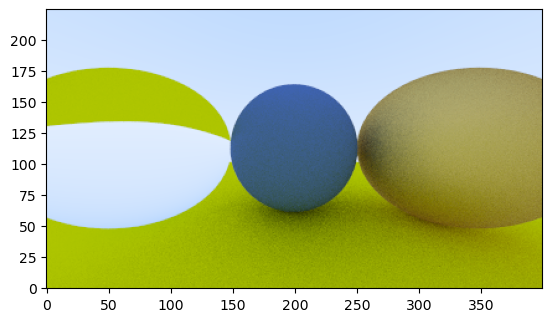

In [22]:
if image.get_device() == 0:
    image_np = image.cpu().numpy()
else:
    image_np = image.numpy()

plt.imshow(image_np, origin="lower")
plt.show()

In [23]:
class Dielectric(Material):
    def __init__(self, index_of_refraction: float):
        self.index_of_refraction = index_of_refraction

    def scatter(self, r_in: Ray, hit_record: "HitRecord") -> tuple[torch.Tensor, torch.Tensor]:
        device = r_in.get_device()

        attenuation = torch.tensor([1.0, 1.0, 1.0], device=device)
        refraction_ratio_map = torch.where(hit_record.is_front_face, 1.0 / self.index_of_refraction, self.index_of_refraction)

        unit_direction_map = f.normalize(r_in.direction_map, dim=-1)

        #
        one = torch.ones(1, device=device)
        cos_theta = torch.minimum(-dot(unit_direction_map, hit_record.normal_map), one)
        sin_theta = torch.sqrt(1.0 - cos_theta**2)

        cannot_refract_map = refraction_ratio_map * sin_theta > 1.0
        reflected_map = reflect(unit_direction_map, hit_record.normal_map)
        refracted_map = refract(unit_direction_map, hit_record.normal_map, refraction_ratio_map)

        direction_map = torch.where(cannot_refract_map, reflected_map, refracted_map)

        scattered_ray = Ray(origin=hit_record.point_map, direction_map=direction_map)
        return attenuation, scattered_ray

In [24]:
# material
material_ground = Lambertian(torch.tensor([0.8, 0.8, 0.0], device=device))
material_center = Lambertian(torch.tensor([0.1, 0.2, 0.5], device=device))
material_left = Dielectric(1.00 / 1.33)
material_right = Metal(torch.tensor([0.8, 0.6, 0.2], device=device), fuzz=1.0)

# world
world = HittableList()
world.add(Sphere(center=torch.tensor([0.0, -100.5, -1.0], device=device), radius=100.0, material=material_ground))
world.add(Sphere(center=torch.tensor([0.0, 0.0, -1.2], device=device), radius=0.5, material=material_center))
world.add(Sphere(center=torch.tensor([-1.0, 0.0, -1.0], device=device), radius=0.5, material=material_left))
world.add(Sphere(center=torch.tensor([ 1.0, 0.0, -1.0], device=device), radius=0.5, material=material_right))

In [25]:
%%time
with torch.no_grad():
    u_map, v_map = get_uv_map(image_width, image_height, device=device)
    ray = camera.get_ray(u_map=u_map, v_map=v_map)

    color_map = ray_color(ray=ray, world=world, depth=max_depth)
    color_map = torch.sum(color_map, dim=2)
    image = scale_color(color_map, num_sample_per_pixel=num_sample_per_pixel)
    image = linear_to_gamma(image)

100%|██████████| 50/50 [00:10<00:00,  4.65it/s]

CPU times: total: 8.95 s
Wall time: 10.8 s


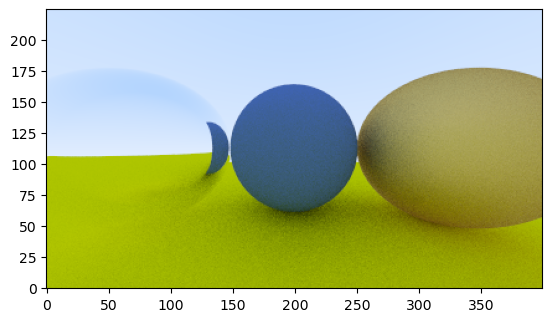

In [26]:
if image.get_device() == 0:
    image_np = image.cpu().numpy()
else:
    image_np = image.numpy()

plt.imshow(image_np, origin="lower")
plt.show()

In [27]:
def reflectance(cosine_map: torch.Tensor, refraction_index_map: torch.Tensor) -> torch.Tensor:
    # Use Schlick's approximation for reflectance.
    r0 = (1 - refraction_index_map) / (1 + refraction_index_map)
    r0 = r0**2
    return r0 + (1 - r0) * (1 - cosine_map)**5


class Dielectric(Material):
    def __init__(self, index_of_refraction: float):
        self.index_of_refraction = index_of_refraction

    def scatter(self, r_in: Ray, hit_record: "HitRecord") -> tuple[torch.Tensor, torch.Tensor]:
        device = r_in.get_device()

        attenuation = torch.tensor([1.0, 1.0, 1.0], device=device)
        refraction_ratio_map = torch.where(hit_record.is_front_face, 1.0 / self.index_of_refraction, self.index_of_refraction)

        unit_direction_map = f.normalize(r_in.direction_map, dim=-1)

        #
        one = torch.ones(1, device=device)
        cos_theta = torch.minimum(-dot(unit_direction_map, hit_record.normal_map), one)
        sin_theta = torch.sqrt(1.0 - cos_theta**2)

        cannot_refract_map = refraction_ratio_map * sin_theta > 1.0
        #
        size = [r_in.height, r_in.width, r_in.num_sample_per_pixel, 1]
        reflectance_map = reflectance(cos_theta, refraction_ratio_map) > torch.rand(size=size, device=device)

        reflected_map = reflect(unit_direction_map, hit_record.normal_map)
        refracted_map = refract(unit_direction_map, hit_record.normal_map, refraction_ratio_map)

        direction_map = torch.where(
            torch.logical_or(cannot_refract_map, reflectance_map),
            reflected_map,
            refracted_map)

        scattered_ray = Ray(origin=hit_record.point_map, direction_map=direction_map)
        return attenuation, scattered_ray

In [28]:
# material
material_ground = Lambertian(torch.tensor([0.8, 0.8, 0.0], device=device))
material_center = Lambertian(torch.tensor([0.1, 0.2, 0.5], device=device))
material_left = Dielectric(1.5)
material_bubble = Dielectric(1.0 / 1.5)
material_right = Metal(torch.tensor([0.8, 0.6, 0.2], device=device), fuzz=1.0)

# world
world = HittableList()
world.add(Sphere(center=torch.tensor([0.0, -100.5, -1.0], device=device), radius=100.0, material=material_ground))
world.add(Sphere(center=torch.tensor([0.0, 0.0, -1.2], device=device), radius=0.5, material=material_center))
world.add(Sphere(center=torch.tensor([-1.0, 0.0, -1.0], device=device), radius=0.5, material=material_left))
world.add(Sphere(center=torch.tensor([-1.0, 0.0, -1.0], device=device), radius=0.4, material=material_bubble))
world.add(Sphere(center=torch.tensor([ 1.0, 0.0, -1.0], device=device), radius=0.5, material=material_right))

In [29]:
%%time
with torch.no_grad():
    u_map, v_map = get_uv_map(image_width, image_height, device=device)
    ray = camera.get_ray(u_map=u_map, v_map=v_map)

    color_map = ray_color(ray=ray, world=world, depth=max_depth)
    color_map = torch.sum(color_map, dim=2)
    image = scale_color(color_map, num_sample_per_pixel=num_sample_per_pixel)
    image = linear_to_gamma(image)

100%|██████████| 50/50 [00:14<00:00,  3.38it/s]

CPU times: total: 10.6 s
Wall time: 14.8 s


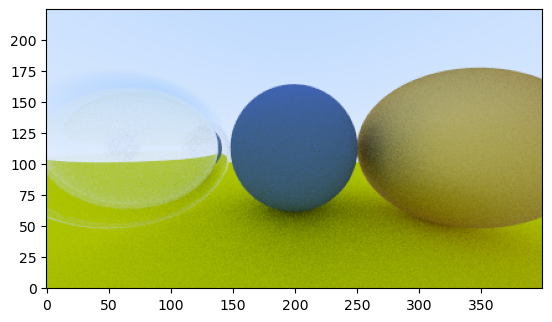

In [30]:
if image.get_device() == 0:
    image_np = image.cpu().numpy()
else:
    image_np = image.numpy()

plt.imshow(image_np, origin="lower")
plt.show()